**基本介绍**

Transformer提出是用于机器翻译领域。在论文中，作者提到：

> Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1,...,x_n)$ to a sequence of continuous representations *$z$*$=(z_1,...,z_n)$. Given $z$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

> The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder

Transformer的构造：

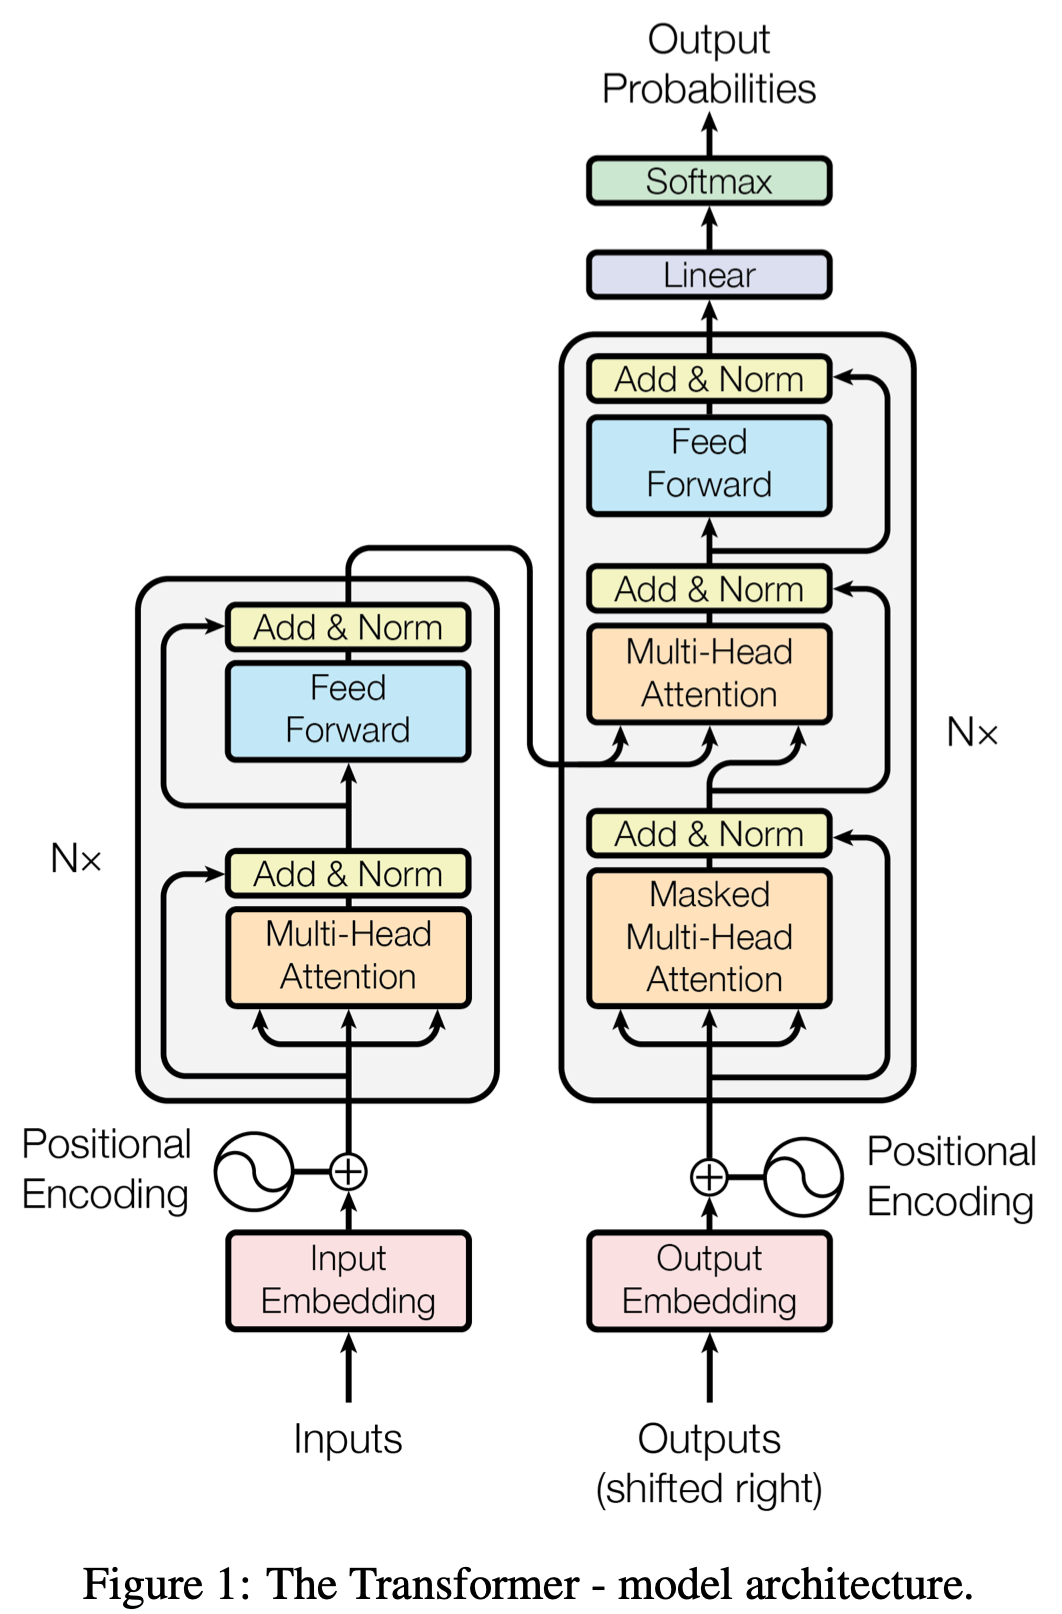



基于Transformer的PT-EN翻译，可学到的内容：
#1、transformer各组件，pos_encoding、编码器(multi-head attention、ffn、以及residual connection)、解码器(与编码器类似，不过有两个multi-head attention，一个是自身上一层输入的的，另一个是enc_out的)
#2、多种不同的mask方式，包括padding_mask以及look_ahead_mask，而且需要借助自动传播机制以对多头进行mask。
> padding_mask是为了处理非定长序列，在self-attention中，q和k点积后需要mask，这时候的enc_padding_mask的shape为(batch,1,1,seq_len_q)，而seq_len_q==seq_len_k，从而实现mask。在encoder和decoder的第二个multi-head attention中，都用到了padding_mask
look_ahead_mask一般是为了防止标签泄露，即在预测下一个词的时候，防止模型提前看到待预测的内容。look_ahead_mask用在decode阶段的第一个multi-head attention用到了，防止看到后面的标签。

#3、学习率调度器、低阶训练框架、训练使用teacher forcing而预测不使用等。

#4、此外，当我们使用低阶 API 构建模型时，不使用fit方法训练的模型，无法使用tf.saved_model.save或model.save来保存成SavedModel格式。
> 若想要保存成SavedModel，有两种方法：
1、需要在call方法上添加@tf.function(input_signature=[tf.TensorSpec([None, 32], tf.float32, name='digits')]) 。且在使用过程中，尤其需要注意数据类型，默认情况下是tf.int32,tf.float32，所以这里最好也是用这些
2、使用_set_inputs(tf.TensorSpec([None, 32], tf.float32, name='digits')方法)

#5、也可以使用高阶fit等方法，这样就需要把所有的inputs放在一个变量里

In [69]:
# 基于Transformer的机器翻译
import tensorflow_datasets as tfds
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import time

%inline matplotlib

UsageError: Line magic function `%inline` not found.


In [37]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /Users/wangjie/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteVER7NG/ted_hrlr_trans…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /Users/wangjie/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteVER7NG/ted_hrlr_trans…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /Users/wangjie/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteVER7NG/ted_hrlr_trans…

Dataset ted_hrlr_translate downloaded and prepared to /Users/wangjie/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [358]:
en_vocab_file = "../DataSet/pt_en_vocabs/en_vocab"
pt_vocab_file = '../DataSet/pt_en_vocabs/pt_vocab'

try:
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
    print(f'载入已建立EN词典: {en_vocab_file}')
except:
    print(f'没有词典，从头建立')
    
    tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (en.numpy() for pt, en in train_examples), target_vocab_size=2**13
    )

    tokenizer_en.save_to_file(en_vocab_file)

try:
    tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.load_from_file(pt_vocab_file)
    print(f'载入已建立PT词典:  {pt_vocab_file}')
except:
    print(f'没有词典，从头建立')
    tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13
    )
    tokenizer_pt.save_to_file(pt_vocab_file)

def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size+1]
    
    return lang1, lang2

def filter_max_length(x, y, max_length=40):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int32, tf.int32])
    result_pt.set_shape([None])
    result_en.set_shape([None])
    
    return result_pt, result_en

BUFFER_SIZE = 20000
BATCH_SIZE = 64



载入已建立EN词典: ../DataSet/pt_en_vocabs/en_vocab
载入已建立PT词典:  ../DataSet/pt_en_vocabs/pt_vocab


In [359]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [360]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int32, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 40), dtype=int32, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]], dtype=int32)>)

In [361]:
# 建模

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        '''
        分头,将(batch, seq_len, d_model) -> (batch, num_heads, seq_len, depth)
        '''
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def scaled_dot_product_attention(self, q, k, v, mask):
        '''
        按比缩放的点积注意力
        q,k,v的前置维度相同，即batch和num_heads
        k,v的倒数第二个维度相同，即seq_len_k = seq_len_v
        '''
        matmul_q_k = tf.matmul(q, k, transpose_b=True) # (batch, num_heads, seq_len_q, seq_len_k)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_q_k / tf.math.sqrt(dk)
        
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (batch, num_heads, seq_len_q, seq_len_k)
        output = tf.matmul(attention_weights, v) # (batch, num_heads, seq_len_q, depth_v)
        return output, attention_weights
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)  # batch, num_heads, seq_len_q, depth
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask) # (batch,)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch, seq_len_q, num_heads, depth_v)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights
        

class PointWiseFFN(tf.keras.layers.Layer):
    def __init__(self, d_model, dff):
        super().__init__()
        self.dense = tf.keras.layers.Dense(dff, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_model)
    
    def call(self, x):
        x = self.dense(x)
        x = self.dense2(x)
        
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PointWiseFFN(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2) / np.float32(d_model)))
    return pos * angle_rates
    
def position_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis, :],
                             d_model
                            )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = position_encoding(maximum_position_encoding, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = PointWiseFFN(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximim_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = position_encoding(maximim_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        return x, attention_weights

transformer_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None, None), dtype=tf.int32),
        tf.TensorSpec(shape=(None), dtype=tf.bool),
        tf.TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1, None, None), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32)
]

    
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                               input_vocab_size=input_vocab_size, maximum_position_encoding=pe_input, rate=rate
                              )
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    @tf.function(input_signature=transformer_signature)
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch, inp_seq_len, d_model)
        
        # Teacher Forcing
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask
        )
        
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
    

In [362]:
# 超参、优化器以及损失函数和指标

NUM_LAYERS = 6
NUM_HEADS = 8
D_MODEL = 128
DFF = 512
EPOCHS = 1

INPUT_VOCAB_SIZE = tokenizer_pt.vocab_size + 2
TARGET_VOCAB_SIZE = tokenizer_en.vocab_size + 2 
DROPOUT_RATE = 0.1

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean('train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [363]:
# 构建掩码
def create_masks(inp, tar):
    # 编码器填充mask
    enc_padding_mask = create_padding_mask(inp)
    
    # 在解码器第二个注意力模块使用，用于遮挡编码器输出
    dec_padding_mask = create_padding_mask(inp)
    
    # 在解码器第一个注意力模块使用，
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

In [406]:
# 检查点
transformer = Transformer(NUM_LAYERS, D_MODEL, NUM_HEADS, DFF, INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE, INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE, DROPOUT_RATE)

checkpoint_path = '../training_checkpoints/transformer'
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored')


Latest checkpoint restored


In [408]:
# 构建训练过程
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    # 训练时使用Teacher Forcing
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)


for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, batch, train_loss.result(), train_accuracy.result()))
        break
    if (epoch+1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(time.time() - start))

tf.saved_model.save(transformer, './trans')

Epoch 1 Batch 0 Loss 1.7267 Accuracy 0.1328
Epoch 1 Loss 1.7267 Accuracy 0.1328
Time take for 1 epoch: 6.2648279666900635 secs



TypeError: in user code:

    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/keras/saving/saving_utils.py:125 _wrapped_model  *
        outputs = model(*args, **kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:885 __call__
        result = self._call(*args, **kwds)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:917 _call
        return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3038 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3416 _maybe_define_function
        self._function_spec.canonicalize_function_inputs(*args, **kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/function.py:2747 canonicalize_function_inputs
        self.signature_summary(), arg))

    TypeError: call(inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask) got two values for argument 'training'


In [409]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size+1]
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    decoder_input = [tokenizer_en.vocab_size]
    out = tf.expand_dims(decoder_input, 0)

    for i in range(40):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, out)
        
        predictions, attention_weights = transformer(encoder_input, out, False, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == tokenizer_en.vocab_size+1:
            print(f'i == {i}')
            return tf.squeeze(out, axis=0), attention_weights

        out = tf.concat([out, predicted_id], axis=-1)
    
    return tf.squeeze(out, axis=0), attention_weights

In [410]:
evaluate("os meus vizinhos ouviram sobre esta ideia")

i == 23


(<tf.Tensor: shape=(24,), dtype=int32, numpy=
 array([8087,   12,   20,    3,  124,    6,    3,  124,    6,    3,  124,
           6,    3,  124,    6,    3,  124,    6,    3,  124,    6,    3,
         160,    2], dtype=int32)>,
 {'decoder_layer1_block1': <tf.Tensor: shape=(1, 8, 24, 24), dtype=float32, numpy=
  array([[[[1.        , 0.        , 0.        , ..., 0.        ,
            0.        , 0.        ],
           [0.51863915, 0.48136076, 0.        , ..., 0.        ,
            0.        , 0.        ],
           [0.23279208, 0.39141896, 0.3757889 , ..., 0.        ,
            0.        , 0.        ],
           ...,
           [0.09242687, 0.02715218, 0.04447987, ..., 0.04215803,
            0.        , 0.        ],
           [0.07330897, 0.02777011, 0.03101295, ..., 0.05806256,
            0.07340017, 0.        ],
           [0.03861519, 0.0371016 , 0.01143515, ..., 0.06764495,
            0.0794179 , 0.04528401]],
  
          [[1.        , 0.        , 0.        , ..., 0.

In [397]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    sentence = sentence.split(' ')
    attention = tf.squeeze(attention[layer], axis=0)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(['<start>']+ sentence + ['<end>'], fontdict=fontdict, rotation=90)
        ax.set_xlabel('Head {}'.format(head+1))
    plt.tight_layout()
    plt.show()
    
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentences = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentences))
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

i == 11
Input: os meus vizinhos ouviram sobre esta ideia .
Output: the first thing i was doing in the first time .


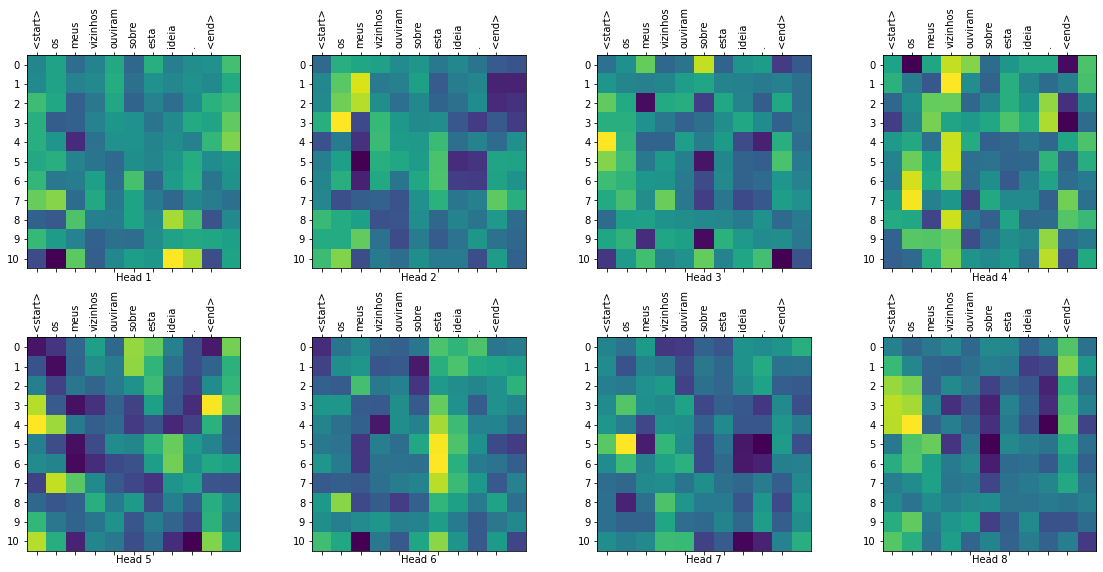

In [398]:
translate('os meus vizinhos ouviram sobre esta ideia .', plot='decoder_layer4_block2')

In [439]:
tf.saved_model.save(transformer, './trans')

TypeError: in user code:

    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/keras/saving/saving_utils.py:125 _wrapped_model  *
        outputs = model(*args, **kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:885 __call__
        result = self._call(*args, **kwds)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:917 _call
        return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3038 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/function.py:3416 _maybe_define_function
        self._function_spec.canonicalize_function_inputs(*args, **kwargs)
    /Users/wangjie/Anaconda/anaconda3/lib/python3.6/site-packages/tensorflow/python/eager/function.py:2747 canonicalize_function_inputs
        self.signature_summary(), arg))

    TypeError: call(inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask) got two values for argument 'training'
